In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\jespe\Documents\GitHub_local\ARFusion


## Functions

In [2]:
results_dict = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'CV_test', 'CV_results.pkl'))

In [3]:
results_dict.keys()

dict_keys(['best_epoch', 'train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

In [4]:
best_epoch_list = results_dict['best_epoch']
losses_list = results_dict['losses']
losses_best = [losses[best_epoch] for losses, best_epoch in zip(losses_list, best_epoch_list)]
accs_list = results_dict['accs']
accs_best = [accs[best_epoch] for accs, best_epoch in zip(accs_list, best_epoch_list)]
iso_accs_list = results_dict['iso_accs']
iso_accs_best = [iso_accs[best_epoch] for iso_accs, best_epoch in zip(iso_accs_list, best_epoch_list)]
sensitivities_list = results_dict['sensitivities']
sens_best = [sensitivities[best_epoch] for sensitivities, best_epoch in zip(sensitivities_list, best_epoch_list)]
specificities_list = results_dict['specificities']
spec_best = [specificities[best_epoch] for specificities, best_epoch in zip(specificities_list, best_epoch_list)]
f1_scores_list = results_dict['F1_scores']
f1_best = [f1_scores[best_epoch] for f1_scores, best_epoch in zip(f1_scores_list, best_epoch_list)]
iso_stats_list = results_dict['iso_stats']
ab_stats_list = results_dict['ab_stats']

In [5]:
def get_best_results(results_dict):
    best_epoch_list = results_dict['best_epoch']
    losses_list = results_dict['losses']
    losses_best = [losses[best_epoch] for losses, best_epoch in zip(losses_list, best_epoch_list)]
    accs_list = results_dict['accs']
    accs_best = [accs[best_epoch] for accs, best_epoch in zip(accs_list, best_epoch_list)]
    iso_accs_list = results_dict['iso_accs']
    iso_accs_best = [iso_accs[best_epoch] for iso_accs, best_epoch in zip(iso_accs_list, best_epoch_list)]
    sensitivities_list = results_dict['sensitivities']
    sens_best = [sensitivities[best_epoch] for sensitivities, best_epoch in zip(sensitivities_list, best_epoch_list)]
    specificities_list = results_dict['specificities']
    spec_best = [specificities[best_epoch] for specificities, best_epoch in zip(specificities_list, best_epoch_list)]
    f1_scores_list = results_dict['F1_scores']
    f1_best = [f1_scores[best_epoch] for f1_scores, best_epoch in zip(f1_scores_list, best_epoch_list)]
    iso_stats_list = results_dict['iso_stats']
    ab_stats_list = results_dict['ab_stats']
    
    best_results = {
        'losses_best': losses_best,
        'accs_best': accs_best,
        'iso_accs_best': iso_accs_best,
        'sens_best': sens_best,
        'spec_best': spec_best,
        'f1_best': f1_best,
        'iso_stats_list': iso_stats_list,
        'ab_stats_list': ab_stats_list
    }
    
    return best_results

def get_average_and_std_df(best_results_dict):
    losses = best_results_dict['losses_best']
    accs = best_results_dict['accs_best']
    iso_accs = best_results_dict['iso_accs_best']
    sensitivities = best_results_dict['sens_best']
    specificities = best_results_dict['spec_best']
    f1_scores = best_results_dict['f1_best']
    
    losses_avg = np.mean(losses)
    losses_std = np.std(losses)
    accs_avg = np.mean(accs)
    accs_std = np.std(accs)
    iso_accs_avg = np.mean(iso_accs)
    iso_accs_std = np.std(iso_accs)
    sens_avg = np.mean(sensitivities)
    sens_std = np.std(sensitivities)
    spec_avg = np.mean(specificities)
    spec_std = np.std(specificities)
    f1_avg = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    df_CV = pd.DataFrame(data={
        "metric": ["Loss", 'Accuracy', 'Isolate accuracy', 'Sensitivity', 'Specificity', 'F1'], 
        "avg": [losses_avg, accs_avg, iso_accs_avg, sens_avg, spec_avg, f1_avg], 
        "std": [losses_std, accs_std, iso_accs_std, sens_std, spec_std, f1_std]
    })
    return df_CV


def get_ab_stats_df(ab_stats_list):
    
    data_dict = {}
    antibiotics = ab_stats_list[0]['antibiotic'].tolist()
    data_dict.update({"antibiotic": antibiotics})
    for ab_stats in ab_stats_list:
        ab_stats['S_share'] = ab_stats['num_S'] / ab_stats['num_tot']
        ab_stats['R_share'] = ab_stats['num_R'] / ab_stats['num_tot']

    s_shares = np.array([ab_stats['S_share'].tolist() for ab_stats in ab_stats_list])
    r_shares = np.array([ab_stats['R_share'].tolist() for ab_stats in ab_stats_list])
    s_share_median = np.median(s_shares, axis=0).tolist()
    s_share_std = np.std(s_shares, axis=0).tolist()
    r_share_median = np.median(r_shares, axis=0).tolist()
    r_share_std = np.std(r_shares, axis=0).tolist()
    data_dict.update({"S_share_median": s_share_median, "R_share_median": r_share_median,
                      "S_share_std":s_share_std, "R_share_std": r_share_std})
    
    metrics = ['accuracy', 'sensitivity', 'specificity', "precision", 'F1']
    for metric in metrics:
        arr = np.array([ab_stats[metric] for ab_stats in ab_stats_list])
        avg = np.mean(arr, axis=0)
        std = np.std(arr, axis=0)
        data_dict.update({metric+"_avg": avg.tolist(), metric+"_std": std.tolist()})

    df_ab_CV = pd.DataFrame(data=data_dict)
    return df_ab_CV
df_ab_CV = get_ab_stats_df(ab_stats_list)

Calculate averages and std. devs.

In [6]:
best_results_dict = get_best_results(results_dict)
df_CV = get_average_and_std_df(best_results_dict)
df_CV['pre-training'] = "none"
df_CV

,metric,avg,std,pre-training
0,Loss,0.160047,0.004227,none
1,Accuracy,0.940999,0.002408,none
2,Isolate accuracy,0.785897,0.008220,none
3,Sensitivity,0.824008,0.012272,none
4,Specificity,0.974685,0.004197,none
5,F1,0.862072,0.005165,none


## Analysis

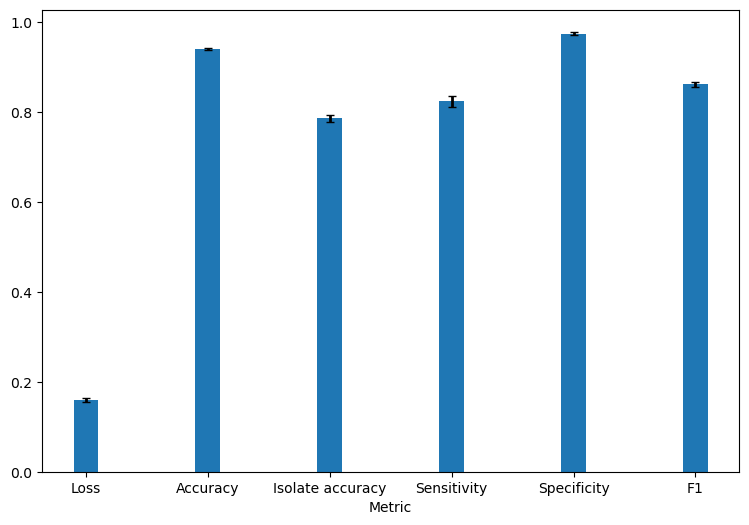

In [7]:
metric_names = ['F1', 'Sensitivity', 'Specificity', 'Accuracy', 'Isolate Accuracy']
fig, ax = plt.subplots(figsize=(9, 6))
ax.bar(df_CV['metric'], df_CV['avg'], width=0.2)
ax.errorbar(df_CV['metric'], df_CV['avg'], df_CV['std'], ecolor="k", fmt="none", elinewidth=2, capsize=3)
ax.set_xlabel("Metric")
plt.show()

In [9]:
df_ab_CV = get_ab_stats_df(best_results_dict)
df_ab_CV

,antibiotic,S_share_median,R_share_median,S_share_std,R_share_std,accuracy_avg,accuracy_std,sensitivity_avg,sensitivity_std,specificity_avg,specificity_std,precision_avg,precision_std,F1_avg,F1_std
0,AMP,0.545362,0.454638,0.007543,0.007543,0.885524,0.013113,0.809951,0.028368,0.946828,0.012839,0.926089,0.015103,0.863829,0.017707
1,CAZ,0.739385,0.260615,0.016625,0.016625,0.926252,0.011713,0.842264,0.019933,0.957720,0.010264,0.882010,0.027314,0.861552,0.021145
2,CIP,0.815297,0.184703,0.002955,0.002955,0.947667,0.005453,0.833947,0.031216,0.973729,0.004903,0.879165,0.020617,0.855439,0.016681
3,CRO,0.808244,0.191756,0.008911,0.008911,0.962325,0.002091,0.879211,0.017626,0.981988,0.003217,0.921124,0.012641,0.899495,0.008639
4,CTX,0.119205,0.880795,0.018091,0.018091,0.961801,0.012533,0.984196,0.005086,0.790499,0.103249,0.972875,0.012413,0.978457,0.006873
5,FEP,0.818444,0.181556,0.007483,0.007483,0.928324,0.011697,0.763322,0.045627,0.965931,0.012632,0.838875,0.045211,0.797516,0.025800
6,GEN,0.878269,0.121731,0.009780,0.009780,0.942055,0.004441,0.643832,0.039871,0.985622,0.004276,0.868307,0.030977,0.737745,0.015413
7,LVX,0.694590,0.305410,0.006649,0.006649,0.942510,0.011674,0.894920,0.026369,0.963396,0.012789,0.915936,0.027552,0.904933,0.019718
8,NAL,0.939706,0.060294,0.002057,0.002057,0.972629,0.003755,0.648370,0.059790,0.993691,0.002559,0.872054,0.041114,0.741148,0.035630
9,TOB,0.919291,0.080709,0.006912,0.006912,0.967896,0.008682,0.712078,0.071318,0.990818,0.005575,0.880355,0.060315,0.784629,0.054947
